# GPU-Accelerated SHAP values with XGBoost 1.3

With the release of XGBoost 1.3 comes an exciting new feature for model interpretability — GPU accelerated SHAP values. SHAP values are a technique for local explainability of model predictions. That is, they give you the ability to examine the impact of various features on model output in a principled way.

In this notebook, we provide an example of training an XGBoost model with SageMaker's XGBoost estimator, and then use SHAP values to identify key features and feature interactions in our dataset. We will be using the California housing dataset. This is a famous dataset of house prices and attributes in California from the 1990 Census, available via scikit-learn.

This notebook was tested in Amazon SageMaker Studio on a ml.t3.medium instance with Python 3 (Data Science) kernel. As a preliminary step, we first ensure that the latest version of SageMaker is installed: 

In [1]:
!pip install -U sagemaker

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


Let's start by specifying:
1. The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.
2. The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regex with a the appropriate full IAM role arn string(s).

In [2]:
%%time

import io
import os
import boto3
import sagemaker
import time

role = sagemaker.get_execution_role()
region = boto3.Session().region_name

# S3 bucket for saving code and model artifacts.
# Feel free to specify a different bucket here if you wish.
bucket = sagemaker.Session().default_bucket()
prefix = "sagemaker/DEMO-xgboost-inference-script-mode"

CPU times: user 789 ms, sys: 135 ms, total: 924 ms
Wall time: 962 ms


## Training the XGBoost model

SageMaker can now run an XGboost script using the XGBoost estimator. A typical training script loads data from the input channels, configures training with hyperparameters, trains a model, and saves a model to `model_dir` so that it can be hosted later. In this notebook, we use the training script **train.py**.

After setting training parameters, we kick off training. 

To run our training script on SageMaker, we construct a `sagemaker.xgboost.estimator.XGBoost` estimator, which accepts several constructor arguments:

* __entry_point__: The path to the Python script SageMaker runs for training and prediction.
* __role__: Role ARN
* __framework_version__: SageMaker XGBoost version you want to use for executing your model training code, e.g., `0.90-1`, `0.90-2`, `1.0-1`, or `1.3-1`. We must use `1.3-1` for GPU accelerated SHAP values.
* __train_instance_type__ *(optional)*: The type of SageMaker instances for training. __Note__: Because Scikit-learn does not natively support GPU training, Sagemaker Scikit-learn does not currently support training on GPU instance types.
* __sagemaker_session__ *(optional)*: The session used to train on Sagemaker.
* __hyperparameters__ *(optional)*: A dictionary passed to the train function as hyperparameters.

In [3]:
from sagemaker.inputs import TrainingInput
from sagemaker.xgboost.estimator import XGBoost

job_name = "DEMO-xgboost-inference-script-mode-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
print("Training job", job_name)

hyperparameters = {
    "max_depth": "6",
    "eta": "0.3",
    "gamma": "0",
    "min_child_weight": "1",
    "subsample": "1",
    "objective": "reg:squarederror",
    "num_round": "500",
    "verbosity": "1",
    "sklearn_dataset": "sklearn.datasets.fetch_california_housing()",
    # using default "tree_method": "gpu_hist" and "predictor": "gpu_predictor"
}

instance_type = "ml.g4dn.xlarge"  # "ml.c5.xlarge"

xgb_script_mode_estimator = XGBoost(
    entry_point="train.py",
    hyperparameters=hyperparameters,
    role=role,
    instance_count=1,
    instance_type=instance_type,
    framework_version="1.3-1",
    output_path="s3://{}/{}/{}/output".format(bucket, prefix, job_name),
)

"""
Since the estimator requires a valid file type but we are specifying a sklearn_dataset, 
we pass in a path to a tiny csv file which will not be used.
"""
content_type = "text/csv"  # MIME type
train_input = TrainingInput(
    "s3://sagemaker-rapids-hpo-us-east-1/dummy_data.csv", content_type=content_type
)

Training job DEMO-xgboost-inference-script-mode-2021-07-02-16-54-32


### Train XGBoost Estimator on California Housing Data

Training is as simple as calling `fit` on the Estimator. This will start a SageMaker Training job that will download the data, invoke the entry point code (in the provided script file), and save any model artifacts that the script creates. 

Note in the cell above that we specify "sklearn_dataset": "sklearn.datasets.fetch_california_housing()" as a parameter in order to use the California housing dataset from scikit-learn. However, calling `fit` on the Estimator requires a valid filepath, but we do not want to have to download the scikit-learn data. Thus as a quick-fix, we refer to a small (only a couple of bytes large) existing dummy CSV file, which is immediately discarded by `train.py` upon receiving a valid "sklearn_dataset" input.

In [4]:
%%time
xgb_script_mode_estimator.fit({"train": train_input}, job_name=job_name)

2021-07-02 16:54:32 Starting - Starting the training job...
2021-07-02 16:54:38 Starting - Launching requested ML instancesProfilerReport-1625244872: InProgress
......
2021-07-02 16:55:38 Starting - Preparing the instances for training............
2021-07-02 16:57:56 Downloading - Downloading input data...
2021-07-02 16:58:32 Training - Training image download completed. Training in progress..[2021-07-02 16:58:34.431 ip-10-0-248-107.ec2.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-07-02:16:58:34:INFO] Imported framework sagemaker_xgboost_container.training
[2021-07-02:16:58:34:INFO] Invoking user training script.
[2021-07-02:16:58:35:INFO] Module train does not provide a setup.py. 
Generating setup.py
[2021-07-02:16:58:35:INFO] Generating setup.cfg
[2021-07-02:16:58:35:INFO] Generating MANIFEST.in
[2021-07-02:16:58:35:INFO] Installing module with the following command:
/miniconda3/bin/python3 -m pip install . 
Processing /opt/ml/code
  DEPRECATION: A future pi

## Deploying the XGBoost endpoint

After training, we can host the newly created model in SageMaker, and create an Amazon SageMaker endpoint – a hosted and managed prediction service that we can use to perform inference. If you call `deploy` after you call `fit` on an XGBoost estimator, it will create a SageMaker endpoint using the training script (i.e., `entry_point`). You can also optionally specify other functions to customize the behavior of deserialization of the input request (`input_fn()`), serialization of the predictions (`output_fn()`), and how predictions are made (`predict_fn()`). If any of these functions are not specified, the endpoint will use the default functions in the SageMaker XGBoost container. See the [SageMaker Python SDK documentation](https://sagemaker.readthedocs.io/en/stable/frameworks/xgboost/using_xgboost.html#sagemaker-xgboost-model-server) for details.

In this notebook, we will run a separate inference script and customize the endpoint to return [SHAP](https://github.com/slundberg/shap) values and interactions in addition to predictions. The inference script that we will run in this notebook is provided as the accompanying file `inference.py`. 

### Deploy to an endpoint

Since the inference script is separate from the training script, here we use `XGBoostModel` to create a model from s3 artifacts and specify `inference.py` as the `entry_point`.

In [5]:
from sagemaker.xgboost.model import XGBoostModel

model_data = xgb_script_mode_estimator.model_data
print(model_data)

xgb_inference_model = XGBoostModel(
    model_data=model_data,
    role=role,
    entry_point="inference.py",
    framework_version="1.3-1",
)

s3://sagemaker-us-east-1-561241433344/sagemaker/DEMO-xgboost-inference-script-mode/DEMO-xgboost-inference-script-mode-2021-07-02-16-54-32/output/DEMO-xgboost-inference-script-mode-2021-07-02-16-54-32/output/model.tar.gz


In [6]:
predictor = xgb_inference_model.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
    serializer=None, deserializer=None,
)

-------------!

Now that we have fetched the dataset and trained an XGBoost regression model with 500 trees (using GPU acceleration), we can generate predictions on the training set. 

In [7]:
predictions = predictor.predict("sklearn.datasets.fetch_california_housing()")

Because the output is a string, we define a method to clean it up and re-cast it as a NumPy array. 

In [8]:
import numpy as np

def clean_array(arr, three_dim=False):
    cleaned_list = []
    arr_count = 0
    for num in arr:
        if '[' in num:
            arr_count += 1
            num = num.replace('[', '')
            cleaned_list.append(float(num))
        elif ']' in num:
            num = num.replace(']', '')
            cleaned_list.append(float(num))
        else: 
            cleaned_list.append(float(num))
            
    array = np.array(cleaned_list, dtype='float32')
    if three_dim:  # shap_interactions will be 3D
        y = int( len(array) / arr_count )
        x = int( arr_count / y )
        array = array.reshape(x, y, y)
    elif(arr_count > 1):
        y = int( len(array) / arr_count )
        array = array.reshape(arr_count, y)
    return array
    
    
predictions = clean_array(predictions[0])

Here, let's plot the distribution of predictions on the training set.

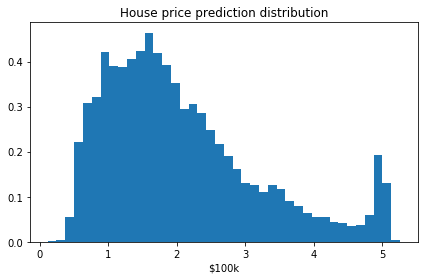

In [9]:
import matplotlib.pyplot as plt

plt.hist(predictions, bins=40, density=True)
plt.title("House price prediction distribution")
plt.xlabel("$100k")
plt.tight_layout()
plt.show()

Here we generate the SHAP values of the training set. The time it took to compute all the SHAP values was: 

In [10]:
import time

start = time.time()
shap_values = predictor.predict("sklearn.datasets.fetch_california_housing(), pred_contribs")
print("SHAP time", time.time() - start)

shap_values = clean_array(shap_values[0])

SHAP time 1.0834386348724365


‘shap_values’ now contains a matrix where each row is a training instance from X and the columns contain the feature attributions (i.e. the amount that each feature contributed to the prediction). The last column in the output shap_values contains the ‘bias’ or the expected output of the model if no features were used. Each row always adds up exactly to the model prediction — this is a unique advantage of SHAP values compared to other model explanation techniques.

Model predictions can be inspected individually using this output, or we can aggregate the SHAP values to gain insight into global feature importance. Here we take the mean absolute contribution of each feature and plot their magnitude.

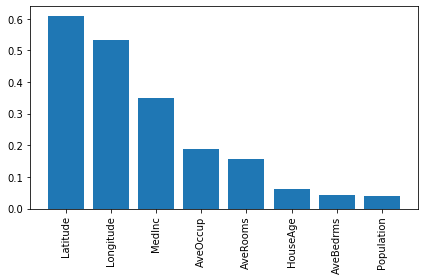

In [11]:
def plot_feature_importance(feature_names, shap_values):
 # Get the mean absolute contribution for each feature
 aggregate = np.mean(np.abs(shap_values[:, 0:-1]), axis=0)
 # sort by magnitude
 z = [(x, y) for y, x in sorted(zip(aggregate, feature_names), reverse=True)]
 z = list(zip(*z))
 plt.bar(z[0], z[1])
 plt.xticks(rotation=90)
 plt.tight_layout()
 plt.show()

feature_names = ["MedInc", "HouseAge", "AveRooms", "AveBedrms", "Population", "AveOccup",
                 "Latitude", "Longitude"]
plot_feature_importance(feature_names, shap_values)

The above chart shows that latitude, longitude, and median income are the most relevant features to our XGBoost model. This chart shows first-order feature relevance, however, we can go deeper and search for second-order effects, or interactions between pairs of features. In the past, it was extremely expensive to search for second-order effects. 

Now with GPUTreeShap we can compute these interaction effects in a matter of seconds, even for large datasets with many features.

In [12]:
start = time.time()
shap_interactions = predictor.predict("sklearn.datasets.fetch_california_housing(), pred_interactions")
print("SHAP interactions time", time.time() - start)

shap_interactions = clean_array(shap_interactions[0], three_dim=True)

SHAP interactions time 6.656414270401001


This is a relatively small dataset with only 8x8 possible feature interactions. For larger datasets, as shown in our paper, GPUTreeShap can reduce feature interaction computations from days to a matter of minutes.

The output ‘shap_interactions’ contains a symmetric matrix of interaction terms for each row, where the element-wise sum evaluates to the model prediction. The diagonal terms represent the main effects for each feature or the impact of that feature excluding second-order interactions.

As before we can aggregate interactions to examine the most significant effects over the training set. This time we plot only the top-k effects due to a large number of possible combinations.

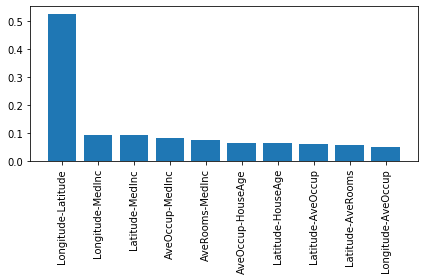

In [13]:
def plot_top_k_interactions(feature_names, shap_interactions, k):
    # Get the mean absolute contribution for each feature interaction
    aggregate_interactions = np.mean(np.abs(shap_interactions[:, :-1, :-1]), axis=0)
    interactions = []
    for i in range(aggregate_interactions.shape[0]):
        for j in range(aggregate_interactions.shape[1]):
            if j < i:
                interactions.append(
                    (feature_names[i] + "-" + feature_names[j], aggregate_interactions[i][j] * 2))
    # sort by magnitude
    interactions.sort(key=lambda x: x[1], reverse=True)
    interaction_features, interaction_values = map(tuple, zip(*interactions))
    plt.bar(interaction_features[:k], interaction_values[:k])
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


plot_top_k_interactions(feature_names, shap_interactions, 10)

Here we see that the SHAP algorithm has identified Latitude-Longitude as the strongest interaction effect by a large margin. While this outcome is somewhat intuitive for the task of house price prediction, given our a priori knowledge of the relatedness of latitude and longitude, the SHAP interactions are useful in algorithmically verifying if the model is behaving according to our human intuition. In cases where the meaning or relationships between features is unclear, it can be used to search for interactions that are not immediately obvious.

### Delete the Endpoint

If you're done with this exercise, please run the `delete_endpoint` line in the cell below.  This will remove the hosted endpoint and avoid any charges from a stray instance being left on.

In [14]:
predictor.delete_endpoint()

# References

- [GPU-Accelerated SHAP values with XGBoost 1.3 and RAPIDS](https://medium.com/rapids-ai/gpu-accelerated-shap-values-with-xgboost-1-3-and-rapids-587fad6822)

- [SageMaker XGBoost Abalone example](https://github.com/aws/amazon-sagemaker-examples/tree/master/introduction_to_amazon_algorithms/xgboost_abalone)

- [SageMaker XGBoost docs](https://sagemaker.readthedocs.io/en/stable/frameworks/xgboost/index.html)